In [116]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Tuple
%matplotlib inline

In [117]:
words = open("names.txt").read().splitlines()

In [118]:
len(words)

32033

In [119]:
chars = sorted(list(set(''.join(words))))
# encoding and decoding chars
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)

In [120]:
# hyperparameters
learning_rate = 0.01
max_epochs = 200000
batch_size = 32
n_embd = 10 # aka C
block_size = 3

In [121]:
# build dataset
def build_dataset (words: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

# make training, validation and test splits
n1, n2 = int(len(words) * 0.8), int(len(words) * 0.9)
X_train, Y_train = build_dataset(words[:n1])
X_valid, Y_valid = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [136]:
# first layer
n_hidden = 200
g = torch.Generator().manual_seed(42)
token_embedding_table = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd * block_size, n_hidden, generator=g) * (5/3)/(n_embd * block_size)**0.5 # Kaiming init 
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # bias not needed with batchnorm

# output layer
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01 # we want small weights
b2 = torch.zeros(vocab_size)

bngain = torch.ones((1, n_hidden)) # batchnorm gain
bnbias = torch.zeros((1, n_hidden)) # batchnorm bias
bnmean_running = torch.zeros((1, n_hidden)) # batchnorm running mean, gaussian so mean is roughly 0
bnstd_running = torch.ones((1, n_hidden)) # batchnorm running std, std is roughly 1
parameters = [token_embedding_table, W1, W2, b2, bngain, bnbias]

In [138]:
for param in parameters:
    param.requires_grad_()

In [139]:
stepi = []
lossi = []

In [140]:
for i in range(max_epochs):
    # construct minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    tok_emb = token_embedding_table[Xb] # T x block_size x C
    emb_cat = tok_emb.view(-1, block_size * n_embd) # T x (block_size * C)
    h_preact =  emb_cat @ W1

    # batch normalization
    mu, sigma = h_preact.mean(dim=0, keepdim=True), h_preact.std(dim=0, keepdim=True)
    h_preact = (h_preact - mu) / sigma
    h_preact = h_preact * bngain + bnbias # scale and shift
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * mu
        bnstd_running = 0.999 * bnstd_running + 0.001 * sigma

    # activation
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) 

    

    if i % 10000 == 0:
        print(f'Step {i:7d} Loss: {loss:.4f}')

    # backward pass
    for p in parameters: # zero out the gradients
        p.grad = None
    loss.backward()

    # update parameters
    lr = learning_rate if i < max_epochs / 2 else learning_rate / 10
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())


Step       0 Loss: 3.3046
Step   10000 Loss: 2.2505
Step   20000 Loss: 2.1246
Step   30000 Loss: 2.1339
Step   40000 Loss: 2.3657
Step   50000 Loss: 2.3567
Step   60000 Loss: 2.0230
Step   70000 Loss: 2.1683
Step   80000 Loss: 2.0397
Step   90000 Loss: 2.5886
Step  100000 Loss: 1.7211
Step  110000 Loss: 2.1276
Step  120000 Loss: 2.3235
Step  130000 Loss: 2.3501
Step  140000 Loss: 2.1897
Step  150000 Loss: 2.2457
Step  160000 Loss: 1.8409
Step  170000 Loss: 2.5195
Step  180000 Loss: 2.1223
Step  190000 Loss: 1.9412


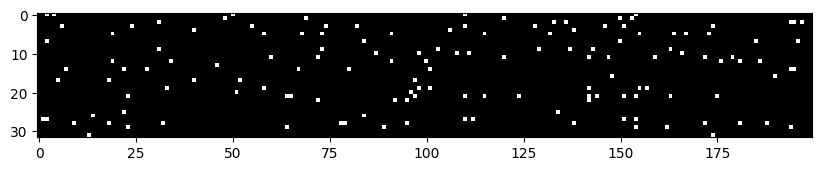

In [141]:
plt.figure(figsize=(10, 6))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest')

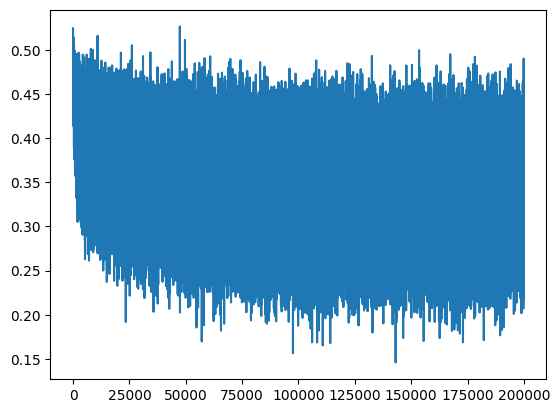

In [142]:
plt.plot(stepi, lossi)

In [143]:
@torch.no_grad()
def split_loss (split: str) -> float:
    x, y = {
        'train': (X_train, Y_train),
        'valid': (X_valid, Y_valid),
        'test': (X_test, Y_test)
    }[split]

    # evaluate loss on validation set
    tok_emb = token_embedding_table[x] # T x block_size x C
    h_preact =  tok_emb.view(-1, block_size * n_embd) @ W1

    # batch normalization
    h_preact = (h_preact - bnmean_running) / bnstd_running
    h_preact = h_preact * bngain + bnbias # scale and shift
    
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    return split, loss.item()

print (split_loss('train'))
print (split_loss('valid'))

('train', 2.1640827655792236)
('valid', 2.17752742767334)


In [144]:
print (split_loss('test'))

('test', 2.1776342391967773)


In [146]:
# generate some names
g = torch.Generator().manual_seed(42)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        tok_emb = token_embedding_table[torch.tensor([context])]
        h_preact = tok_emb.view(1, -1) @ W1

        # batch normalization
        h_preact = (h_preact - bnmean_running) / bnstd_running
        h_preact = h_preact * bngain + bnbias # scale and shift

        h = torch.tanh(h_preact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix) 
        if itos[ix] == '.':
            break
    print(''.join(itos[i] for i in out))

anueden.
tis.
marian.
dan.
shan.
silayley.
kemarie.
man.
epiachaleilanzi.
kence.
jordon.
kalla.
makhiyah.
acvisia.
aceelani.
naretdeel.
mar.
tal.
jente.
solan.
